In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configurações para os gráficos
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 7)

In [2]:
# --- Carregamento dos Dados ---
import glob

# Carregar a tabela de features v3 (resultado do notebook 04)
path_base = '../data/processed/feature_table_v3.parquet'
df_base = pd.read_parquet(path_base)
print(f"Tabela base carregada com {df_base.shape[0]} registros e {df_base.shape[1]} colunas.")

# --- Lógica para carregar múltiplos arquivos anuais ---
def carregar_dados_anuais(caminho_padrao, separador=';', decimal=','): # Adicionamos o decimal aqui como padrão
    """Função para encontrar, ler e concatenar múltiplos arquivos CSV anuais."""
    lista_arquivos = glob.glob(caminho_padrao)
    if not lista_arquivos:
        raise FileNotFoundError(f"Nenhum arquivo encontrado para o padrão: {caminho_padrao}")
    lista_dfs = []
    for arquivo in lista_arquivos:
        print(f"Lendo o arquivo: {arquivo}")
        # CORREÇÃO: Usando o parâmetro 'decimal' na leitura do CSV
        df_ano = pd.read_csv(arquivo, sep=separador, decimal=decimal)
        lista_dfs.append(df_ano)
    return pd.concat(lista_dfs, ignore_index=True)

try:
    print("\n--- Carregando dados de EAR ---")
    padrao_ear = '../data/raw/EAR_DIARIO_SUBSISTEMA_*.csv'
    df_ear_raw = carregar_dados_anuais(padrao_ear, separador=';', decimal=',')
    print(f"-> {len(df_ear_raw)} registros de EAR carregados.")
    
    print("\n--- Carregando dados de ENA ---")
    padrao_ena = '../data/raw/ENA_DIARIO_SUBSISTEMA_*.csv'
    df_ena_raw = carregar_dados_anuais(padrao_ena, separador=';', decimal=',')
    print(f"-> {len(df_ena_raw)} registros de ENA carregados.")

    print("\nVerificando o tipo de dado da coluna de EAR (deve ser float):")
    df_ear_raw.info()

except Exception as e:
    print(f"ERRO CRÍTICO: Falha ao ler os arquivos CSV. Verifique os nomes e caminhos. Erro: {e}")
    raise

Tabela base carregada com 5728 registros e 13 colunas.

--- Carregando dados de EAR ---
Lendo o arquivo: ../data/raw/EAR_DIARIO_SUBSISTEMA_2022.csv
Lendo o arquivo: ../data/raw/EAR_DIARIO_SUBSISTEMA_2012.csv
Lendo o arquivo: ../data/raw/EAR_DIARIO_SUBSISTEMA_2021.csv
Lendo o arquivo: ../data/raw/EAR_DIARIO_SUBSISTEMA_2025.csv
Lendo o arquivo: ../data/raw/EAR_DIARIO_SUBSISTEMA_2014.csv
Lendo o arquivo: ../data/raw/EAR_DIARIO_SUBSISTEMA_2017.csv
Lendo o arquivo: ../data/raw/EAR_DIARIO_SUBSISTEMA_2013.csv
Lendo o arquivo: ../data/raw/EAR_DIARIO_SUBSISTEMA_2024.csv
Lendo o arquivo: ../data/raw/EAR_DIARIO_SUBSISTEMA_2019.csv
Lendo o arquivo: ../data/raw/EAR_DIARIO_SUBSISTEMA_2015.csv
Lendo o arquivo: ../data/raw/EAR_DIARIO_SUBSISTEMA_2020.csv
Lendo o arquivo: ../data/raw/EAR_DIARIO_SUBSISTEMA_2023.csv
Lendo o arquivo: ../data/raw/EAR_DIARIO_SUBSISTEMA_2010.csv
Lendo o arquivo: ../data/raw/EAR_DIARIO_SUBSISTEMA_2011.csv
Lendo o arquivo: ../data/raw/EAR_DIARIO_SUBSISTEMA_2018.csv
Lendo o arqu

In [3]:
# --- Processamento - Energia Armazenada ---

coluna_data_ear = 'ear_data'
coluna_subsistema_ear = 'nom_subsistema'
coluna_valor_ear = 'ear_verif_subsistema_percentual'

df_ear = df_ear_raw[[coluna_data_ear, coluna_subsistema_ear, coluna_valor_ear]].copy()

df_ear[coluna_valor_ear] = pd.to_numeric(df_ear[coluna_valor_ear], errors='coerce')

df_ear.rename(columns={coluna_valor_ear: 'ear_percentual_seco'}, inplace=True)
df_ear['timestamp'] = pd.to_datetime(df_ear[coluna_data_ear])
df_ear_seco = df_ear[df_ear[coluna_subsistema_ear] == 'SUDESTE'].copy()
df_ear_seco.set_index('timestamp', inplace=True)

print("Feature de Energia Armazenada (EAR) foi criada.")
display(df_ear_seco.head())

Feature de Energia Armazenada (EAR) foi criada.


,ear_data,nom_subsistema,ear_percentual_seco
timestamp,,,
2022-01-01,2022-01-01,SUDESTE,26.204100
2022-01-02,2022-01-02,SUDESTE,26.791401
2022-01-03,2022-01-03,SUDESTE,27.285000
2022-01-04,2022-01-04,SUDESTE,27.845200
2022-01-05,2022-01-05,SUDESTE,28.472500


In [4]:
# --- Processamento - Energia Afluente (ENA) ---

coluna_data_ena = 'ena_data'
coluna_subsistema_ena = 'nom_subsistema'
coluna_valor_ena_percentual = 'ena_bruta_regiao_percentualmlt'

df_ena = df_ena_raw[[coluna_data_ena, coluna_subsistema_ena, coluna_valor_ena_percentual]].copy()
df_ena.rename(columns={coluna_valor_ena_percentual: 'ena_percentual_mlt_seco'}, inplace=True)

df_ena['timestamp'] = pd.to_datetime(df_ena[coluna_data_ena])

df_ena_seco = df_ena[df_ena[coluna_subsistema_ena] == 'SUDESTE'].copy()

df_ena_seco.set_index('timestamp', inplace=True)

print("Feature de Energia Afluente (ENA) foi criada.")
display(df_ena_seco.head())

Feature de Energia Afluente (ENA) foi criada.


,ena_data,nom_subsistema,ena_percentual_mlt_seco
timestamp,,,
2010-01-01,2010-01-01,SUDESTE,146.30000305
2010-01-02,2010-01-02,SUDESTE,150.63000488
2010-01-03,2010-01-03,SUDESTE,150.22999573
2010-01-04,2010-01-04,SUDESTE,147.24000549
2010-01-05,2010-01-05,SUDESTE,143.44999695


In [5]:
# --- Junção (Merge) de Todas as Features (SINTAXE MELHORADA) ---

df_combinado = df_base.copy()
df_combinado = df_combinado.join(df_ear_seco[['ear_percentual_seco']])
df_combinado = df_combinado.join(df_ena_seco[['ena_percentual_mlt_seco']])

df_combinado['ear_percentual_seco'] = df_combinado['ear_percentual_seco'].ffill()
df_combinado['ena_percentual_mlt_seco'] = df_combinado['ena_percentual_mlt_seco'].ffill()
df_combinado = df_combinado.bfill()
df_combinado = df_combinado.fillna(0)

print("Tabela final combinada (Alvo + Carga + Geração + Rede + Hídrica):")
print("\nContagem de nulos após o preenchimento:")
print(df_combinado.isnull().sum().sum()) # Deve ser 0
display(df_combinado.head())

Tabela final combinada (Alvo + Carga + Geração + Rede + Hídrica):

Contagem de nulos após o preenchimento:
0


,deficit_diario_mwh,nivel_risco,programada,verificada,diferenca_verif_prog,geracao_total_diaria_go,geracao_eolielétrica_diaria,geracao_fotovoltaica_diaria,geracao_hidroelétrica_diaria,geracao_nuclear_diaria,geracao_térmica_diaria,total_mwh_restrito_go,saldo_intercambio_seco,ear_percentual_seco,ena_percentual_mlt_seco
timestamp,,,,,,,,,,,,,,,
2010-01-06,458.4,alto,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73.250000,138.38999939
2010-01-07,4.6,medio,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73.269997,134.27999878
2010-01-08,0.0,baixo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73.379997,131.52999878
2010-01-09,0.0,baixo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73.500000,129.33000183
2010-01-10,0.0,baixo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73.589996,125.76000214


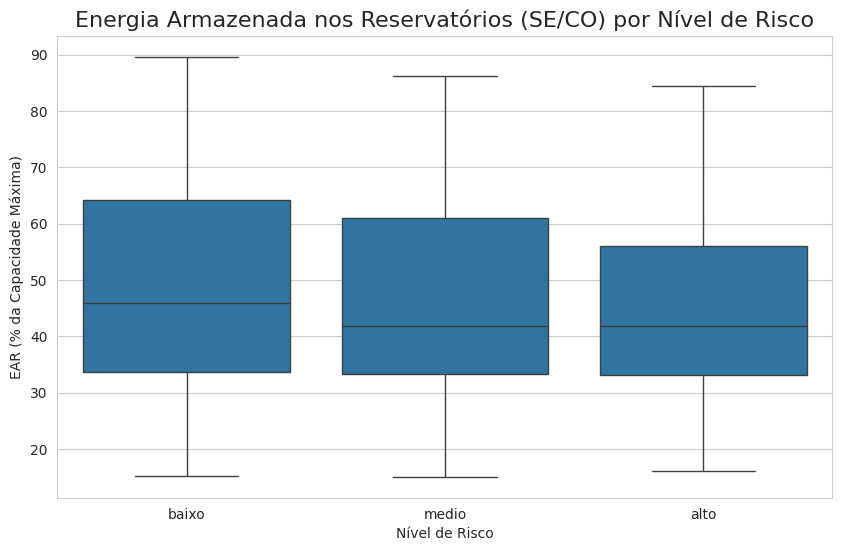

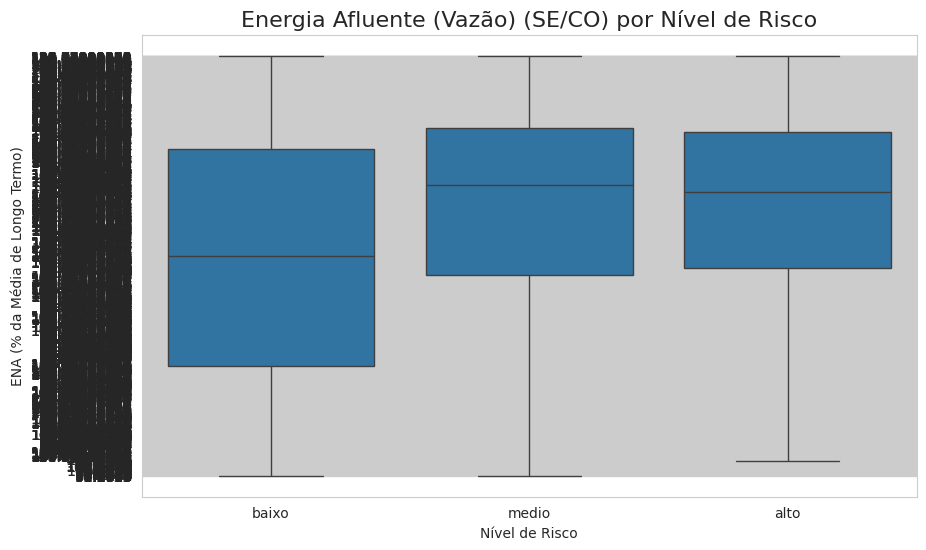

In [6]:
# Gráfico 1: Energia Armazenada (EAR) por Nível de Risco
plt.figure(figsize=(10, 6))
sns.boxplot(x='nivel_risco', y='ear_percentual_seco', data=df_combinado, order=['baixo', 'medio', 'alto'])
plt.title('Energia Armazenada nos Reservatórios (SE/CO) por Nível de Risco', fontsize=16)
plt.ylabel('EAR (% da Capacidade Máxima)')
plt.xlabel('Nível de Risco')
plt.show()

# Gráfico 2: Energia Afluente (ENA) por Nível de Risco
plt.figure(figsize=(10, 6))
sns.boxplot(x='nivel_risco', y='ena_percentual_mlt_seco', data=df_combinado, order=['baixo', 'medio', 'alto'])
plt.title('Energia Afluente (Vazão) (SE/CO) por Nível de Risco', fontsize=16)
plt.ylabel('ENA (% da Média de Longo Termo)')
plt.xlabel('Nível de Risco')
plt.show()

In [7]:
# --- Salvando a Tabela Final para Modelagem ---

# Define e cria o diretório de saída se não existir
output_path = '../data/processed/feature_table_final.parquet'
output_dir = os.path.dirname(output_path)
os.makedirs(output_dir, exist_ok=True)

# Salva a tabela final, pronta para a fase de Machine Learning
df_combinado.to_parquet(output_path)

print(f"TABELA FINAL PRONTA PARA MODELAGEM salva com sucesso em: {output_path}")
print(f"A tabela contém {df_combinado.shape[0]} dias e {df_combinado.shape[1]} colunas (features + alvo).")

TABELA FINAL PRONTA PARA MODELAGEM salva com sucesso em: ../data/processed/feature_table_final.parquet
A tabela contém 5728 dias e 15 colunas (features + alvo).
